#Lib


In [3]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

import random


import tensorflow as tf


from tensorflow.keras import layers, models

#Parameter


In [4]:
# Số lượng đơn vị y tế (I) và số loại nguồn lực (J=3: Vaccine, Doctor, Bed)
I = 10  # Giả sử có 5 đơn vị y tế
J = 3  # 3 loại nguồn lực



expense = np.random.randint(100, 200, size=(I, J))

print("Expense:", expense)

T_budget =np.random.randint(1000, 10000, size = 3) * 10  # Tăng ngân sách
print("Total budget (B_max):", T_budget)

patient = np.random.randint(100, 1000, size= I)  # Giảm số bệnh nhân tối đa


demand = np.random.randint(1, 20, size=(I, J))
print("Demand:", demand)

c = expense
B_max = T_budget
P_a = patient.reshape(I, 1)
print("Patient:", P_a)

w = np.random.rand(I, J)   # Giảm trọng số
print(w)

d_e = demand

rho = 100

print("sdasdasfcvc:", w*P_a)
#


Expense: [[158 162 193]
 [157 180 112]
 [182 167 173]
 [111 142 164]
 [182 198 117]
 [118 194 122]
 [110 105 158]
 [157 152 152]
 [130 174 137]
 [157 117 144]]
Total budget (B_max): [68300 26290 41270]
Demand: [[12  9 11]
 [15  5 13]
 [ 3 10  5]
 [ 8  4  9]
 [10  5  5]
 [ 2  2 17]
 [ 7 12 19]
 [15  3 19]
 [ 3 19  2]
 [ 3 14 14]]
Patient: [[863]
 [847]
 [433]
 [720]
 [522]
 [277]
 [742]
 [355]
 [365]
 [790]]
[[0.4837695  0.48811643 0.64097283]
 [0.84623967 0.98806367 0.58919184]
 [0.06375329 0.84744888 0.67951274]
 [0.14341602 0.60429472 0.28912173]
 [0.29760691 0.77023164 0.7319514 ]
 [0.50891947 0.43456577 0.28731327]
 [0.22992639 0.52362341 0.66428617]
 [0.58915836 0.43197908 0.62890868]
 [0.78417123 0.34384664 0.62924271]
 [0.75832974 0.39527378 0.93789649]]
sdasdasfcvc: [[417.49308139 421.24447716 553.15955255]
 [716.76500342 836.88993002 499.0454862 ]
 [ 27.60517512 366.94536476 294.22901474]
 [103.2595341  435.09219899 208.16764318]
 [155.35080822 402.06091728 382.07863291]
 [140

#CVXpy

Expense: [[158 162 193]
 [157 180 112]
 [182 167 173]
 [111 142 164]
 [182 198 117]
 [118 194 122]
 [110 105 158]
 [157 152 152]
 [130 174 137]
 [157 117 144]]
Total budget (B_max): [68300 26290 41270]
                                     CVXPY                                     
                                     v1.6.5                                    
(CVXPY) May 12 05:48:43 PM: Your problem has 30 variables, 64 constraints, and 0 parameters.
(CVXPY) May 12 05:48:43 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 12 05:48:43 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 12 05:48:43 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) May 12 05:48:43 PM: Your problem is compiled with the CPP canonicalization backend.
CBC solver not found. Trying default solver.
                                     CVXPY                      

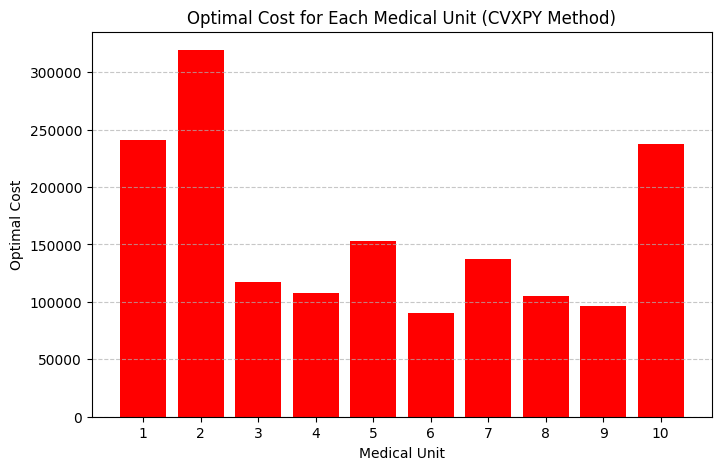

In [5]:




# Khai báo biến quyết định
x = cp.Variable((I, J), integer=True)

# ------------------------Parameter----------------------------------

print("Expense:", expense)

S = cp.maximum(d_e - x, 0)

# -----------------Objective function-------------------------------
objective = cp.Minimize(cp.sum(cp.multiply(c, x) + rho * S))

# -----------------Constraints----------------------------------------
constraints = []

# Ràng buộc tổng tài nguyên
for j in range(J):
    constraints.append(cp.sum(x[:, j]) <= B_max[j])

# Ràng buộc phân bổ tối thiểu
for i in range(I):
    constraints.append(x[i, :] >= w[i, :] * P_a[i])

# Ràng buộc chênh lệch phân bổ
min_alloc = cp.min(cp.sum(x, axis=1))
max_alloc = cp.max(cp.sum(x, axis=1))
constraints.append(max_alloc <= 3 * min_alloc)

# Ràng buộc không âm
constraints.append(x >= 0)

# In thông tin để kiểm tra
print("Total budget (B_max):", B_max)


# -----------------Solve problem----------------------------------------
prob = cp.Problem(objective, constraints)

try:
    prob.solve(solver=cp.CBC, verbose=True)
except cp.SolverError:
    print("CBC solver not found. Trying default solver.")
    prob.solve(solver=cp.GLPK_MI, verbose=True)

# -----------------Conclusions----------------------------------------
if prob.status == cp.OPTIMAL or prob.status == cp.OPTIMAL_INACCURATE:
    print("Optimal allocation of resources:")
    print(x.value)

    optimal_costs = np.sum(c * x.value, axis=1)
    print("Optimal costs for each medical unit:", optimal_costs)
    print("Total optimal cost:", np.sum(optimal_costs, axis=None))

    # Vẽ biểu đồ chi phí tối ưu theo từng đơn vị y tế
    plt.figure(figsize=(8, 5))
    plt.bar(range(1, I+1), optimal_costs, color='red')
    plt.xlabel("Medical Unit")
    plt.ylabel("Optimal Cost")
    plt.title("Optimal Cost for Each Medical Unit (CVXPY Method)")
    plt.xticks(range(1, I+1))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
else:
    print("Problem could not be solved. Status:", prob.status)


#GA-Genetic Algorithm

Generation 0: best cost = 8590031.0
Generation 1: best cost = 8589347.0
Generation 2: best cost = 8392596.0
Generation 3: best cost = 7914057.0
Generation 4: best cost = 8246658.0
Generation 5: best cost = 7802634.0
Generation 6: best cost = 7280422.0
Generation 7: best cost = 7416713.0
Generation 8: best cost = 6755243.0
Generation 9: best cost = 6784221.0
Generation 10: best cost = 6638442.0
Generation 11: best cost = 6424931.0
Generation 12: best cost = 6113413.0
Generation 13: best cost = 5906795.0
Generation 14: best cost = 5654398.0
Generation 15: best cost = 5713741.0
Generation 16: best cost = 5482576.0
Generation 17: best cost = 5442617.0
Generation 18: best cost = 5118335.0
Generation 19: best cost = 5118335.0
Generation 20: best cost = 4977944.0
Generation 21: best cost = 4769388.0
Generation 22: best cost = 4460643.0
Generation 23: best cost = 4525071.0
Generation 24: best cost = 4369655.0
Generation 25: best cost = 4315625.0
Generation 26: best cost = 4195095.0
Generation 

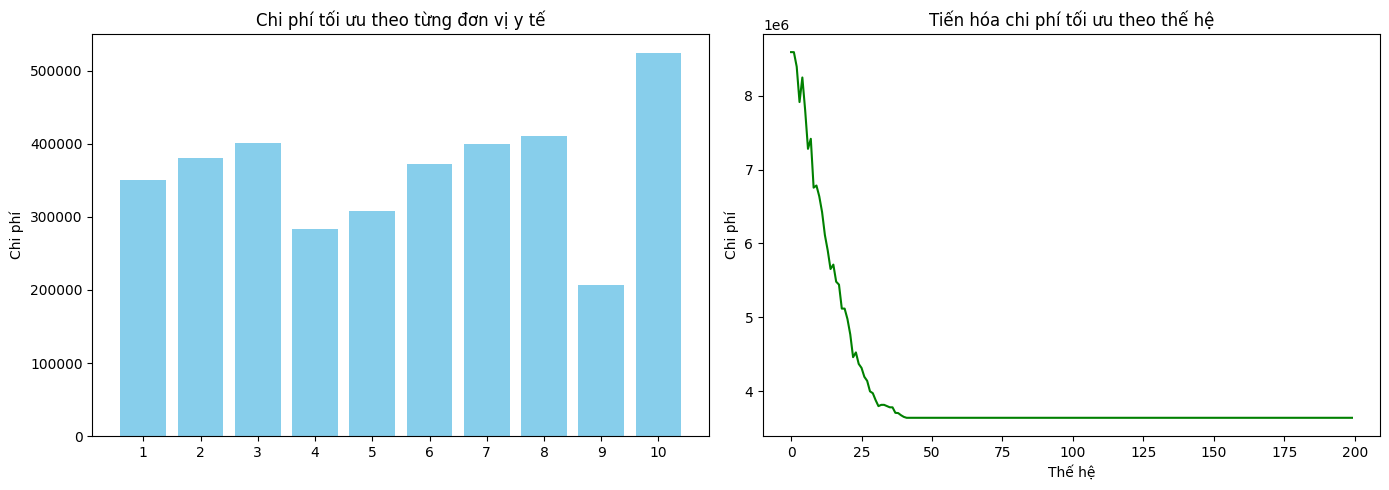

In [6]:


x = np.zeros((I, J))
S = np.zeros((I, J))

# Hàm chi phí
def evaluate(x):

    x = np.array(x).reshape((I, J))

    # ----------------------------------------
    # for uint in range(I):
    #     for  resource in range(J):
    S = np.maximum(d_e - x, 0)
    # print("âsfasdfsdfsdfsfdsgvsfsfsfefrwefegrvdfgd", S )

    # ----------------------------------------

    return np.sum(c * x + rho*S)

# Kiểm tra ràng buộc
def check_constraints(x):
    x = np.array(x).reshape((I, J))

    # Ràng buộc tổng tài nguyên không vượt quá giới hạn
    if np.any(np.sum(x, axis=0) > B_max):
        return False

    # Ràng buộc phân bổ tối thiểu
    for i in range(I):
        for j in range(J):
            # if x[i, j] < w[i, j] * p[i]:
            if x[i, j] < w[i, j] * P_a[i]:
                return False

    # Ràng buộc chênh lệch phân bổ giữa các đơn vị
    total_per_unit = np.sum(x, axis=1)
    if np.max(total_per_unit) > 3 * np.min(total_per_unit):
        return False

    return True

# Tạo cá thể ngẫu nhiên ========================================================

# def generate_individual():
#     x = np.zeros((I, J))
#     for i in range(I):
#         for j in range(J):
#             # x[i, j] = np.random.randint(int(w[i, j]*p[i]), int(B_max[j]/I)+1)
#             x[i, j] = np.random.randint(int(w[i, j]*P_a[i]), int(B_max[j]/I)+1)

#     return x.flatten()

def generate_individual():
    x = np.zeros((I, J))
    for j in range(J):
        remaining = B_max[j]  # Tài nguyên còn lại
        min_allocs = w[:, j] * P_a.flatten()
        for i in range(I):
            min_alloc = int(min_allocs[i])
            max_alloc = min(int(remaining / (I - i)), int(B_max[j] / I) + 1)
            if max_alloc < min_alloc:
                return generate_individual()  # Thử lại nếu không khả thi
            x[i, j] = np.random.randint(min_alloc, max_alloc + 1)
            remaining -= x[i, j]
    return x.flatten()

# # =================================================================================

# Lai ghép
def crossover(p1, p2):
    point = np.random.randint(1, len(p1) - 1)
    return np.concatenate([p1[:point], p2[point:]])

# Đột biến ==================================================================

# def mutate(x, mutation_rate=0.1):
#     for i in range(len(x)):
#         if np.random.rand() < mutation_rate:
#             x[i] += np.random.randint(-3, 4)
#             x[i] = max(x[i], 0)
#     return x

def mutate(x, mutation_rate=0.):
    x = np.array(x).reshape((I, J))
    min_allocs = w * P_a
    if np.random.rand() < mutation_rate:
        # Đột biến ngẫu nhiên một hàng
        i = np.random.randint(0, I)
        for j in range(J):
            delta = np.random.randint(-3, 5)
            x[i, j] += delta
            x[i, j] = max(x[i, j], int(min_allocs[i, j]))
    return x.flatten()
# # ==========================================================================
# Chạy GA
def run_ga(pop_size=200, generations=200):
    population = [generate_individual() for _ in range(pop_size)]
    best_costs_per_gen = []

    for gen in range(generations):
        scores = []
        for ind in population:
            score = evaluate(ind) if check_constraints(ind) else float('inf')
            scores.append(score)

        best_score = min(scores)
        best_individual = population[np.argmin(scores)]
        best_costs_per_gen.append(best_score)

        print(f"Generation {gen}: best cost = {best_score}")

        # Chọn lọc và tái tạo
        sorted_indices = np.argsort(scores)
        selected = [population[i] for i in sorted_indices[:pop_size//2]]

        children = []
        while len(children) < pop_size:
            # Convert selected to a 1D array of indices before using np.random.choice
            selected_indices = np.arange(len(selected))
            parent_indices = np.random.choice(selected_indices, 2, replace=False)
            parents = [selected[i] for i in parent_indices]

            child = crossover(parents[0], parents[1])
            child = mutate(child)
            children.append(child)

        population = children

    return np.array(best_individual).reshape((I, J)), best_costs_per_gen

# === Chạy thuật toán GA ===
optimal_X, best_costs = run_ga()

print("Optimal Allocation of Resources:")
print(optimal_X)
print("Total best Cost:", np.min(best_costs))


# === Vẽ biểu đồ ===
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Biểu đồ chi phí theo đơn vị y tế
costs_per_unit = np.sum(optimal_X * c, axis=1)
print("cost per unit",costs_per_unit)
print("total Cost", np.sum(costs_per_unit, axis=None))

axs[0].bar([f'{i+1}' for i in range(I)], costs_per_unit, color='skyblue')
axs[0].set_title('Chi phí tối ưu theo từng đơn vị y tế')
axs[0].set_ylabel('Chi phí')

# Biểu đồ tiến hóa chi phí
axs[1].plot(best_costs, color='green')
axs[1].set_title('Tiến hóa chi phí tối ưu theo thế hệ')
axs[1].set_xlabel('Thế hệ')
axs[1].set_ylabel('Chi phí')

plt.tight_layout()
plt.show()


#random method


Best cost: 8412727.0
Best individual (x): [[ 919. 1380. 3583.]
 [1497. 2360. 1648.]
 [2852. 1756.  450.]
 [3703. 1365.  756.]
 [ 544. 2534. 3504.]
 [1026. 2000. 2309.]
 [ 664. 1911.  626.]
 [5252. 2010.  453.]
 [ 702. 1058. 2429.]
 [3677.  609. 1801.]]
the cost per unit [1060281.  844405.  890166.  728847. 1010708.  790766.  372603. 1198940.
  608125.  907886.]
total Cost 8412727.0


Text(0, 0.5, 'Chi phí')

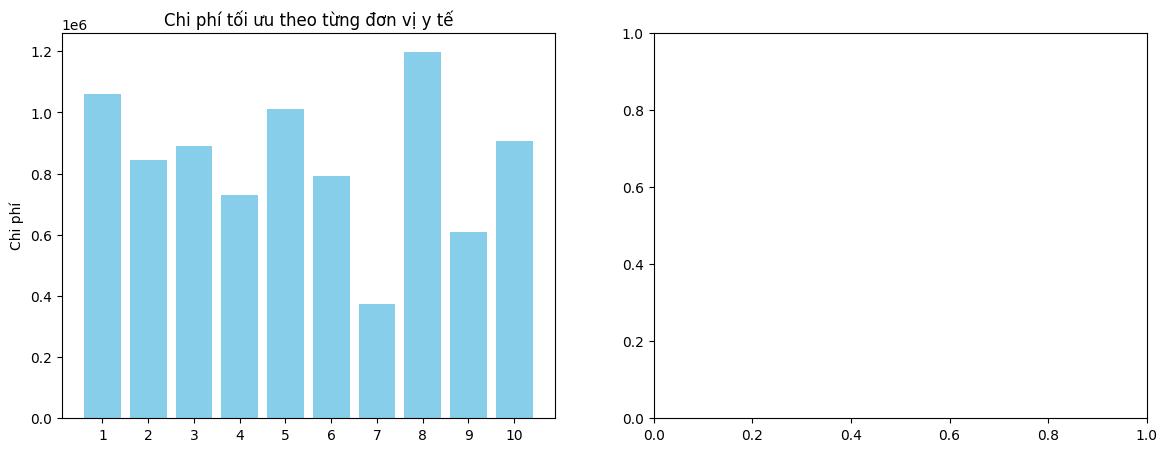

In [7]:
def generate_individual():
    x = np.zeros((I, J))
    for j in range(J):
        remaining = B_max[j]  # Tài nguyên còn lại
        min_allocs = w[:, j] * P_a.flatten()
        for i in range(I):
            min_alloc = int(min_allocs[i])
            max_alloc = min(int(remaining / (I - i)), int(B_max[j] / I) + 1)
            if max_alloc < min_alloc:
                return generate_individual()  # Thử lại nếu không khả thi
            x[i, j] = np.random.randint(min_alloc, max_alloc + 1)
            remaining -= x[i, j]
    return x.flatten()

def evaluate(x):

    x = np.array(x).reshape((I, J))

    # ----------------------------------------

    S = np.maximum(d_e - x, 0)
    # print("âsfasdfsdfsdfsfdsgvsfsfsfefrwefegrvdfgd", S )

    # ----------------------------------------

    return np.sum(c * x + rho*S)

def check_constraints(x):
    x = np.array(x).reshape((I, J))

    # Ràng buộc tổng tài nguyên không vượt quá giới hạn
    if np.any(np.sum(x, axis=0) > B_max):
        return False

    # Ràng buộc phân bổ tối thiểu
    for i in range(I):
        for j in range(J):
            # if x[i, j] < w[i, j] * p[i]:
            if x[i, j] < w[i, j] * P_a[i]:
                return False

    # Ràng buộc chênh lệch phân bổ giữa các đơn vị
    total_per_unit = np.sum(x, axis=1)
    if np.max(total_per_unit) > 3 * np.min(total_per_unit):
        return False

    return True

def random(num, max_attempts=1000):
    best_solutions = []  # mỗi phần tử là (cost, x)

    for _ in range(num):
        attempts = 0
        while attempts < max_attempts:
            x = generate_individual()
            if check_constraints(x):
                cost = evaluate(x)
                best_solutions.append((cost, x))
                break
            attempts += 1
        else:
            print("Không thể tạo cá thể hợp lệ sau", max_attempts, "lần.")

    if not best_solutions:
        return None, None

    # Tìm tuple có cost nhỏ nhất
    best_cost, best_x = min(best_solutions, key=lambda t: t[0])
    return best_cost, best_x


cost, solution = random(100)
print("Best cost:", cost)
print("Best individual (x):", solution.reshape(10,3))


fig, axs = plt.subplots(1, 2, figsize=(14, 5))

cost_random_for_unit = np.sum(c * solution.reshape(I, J) + rho * S, axis=1)
print ("the cost per unit", cost_random_for_unit)
print("total Cost", np.sum(cost_random_for_unit, axis=None))

axs[0].bar([f'{i+1}' for i in range(I)], cost_random_for_unit, color='skyblue')
axs[0].set_title('Chi phí tối ưu theo từng đơn vị y tế')
axs[0].set_ylabel('Chi phí')

#DNN


##create data


In [8]:
def generate_Dl():
    x = np.zeros((I, J))
    for j in range(J):
        remaining = B_max[j]
        min_allocs = np.ceil(w[:, j] * P_a.flatten()).astype(int)

        for i in range(I):
            min_alloc = int(min_allocs[i])
            max_alloc = min(int(remaining), min_alloc + 10)  # Giới hạn để tránh over

            if max_alloc < min_alloc:
                return generate_Dl()  # Thử lại nếu không khả thi

            x[i, j] = np.random.randint(min_alloc, max_alloc + 1)
            remaining -= x[i, j]

    return x.flatten()


def check_constraints(x):
    x = np.array(x).reshape((I, J))

    # Ràng buộc tổng tài nguyên không vượt quá giới hạn
    if np.any(np.sum(x, axis=0) > B_max):
        return False

    # Ràng buộc phân bổ tối thiểu
    for i in range(I):
        for j in range(J):
            # if x[i, j] < w[i, j] * p[i]:
            if x[i, j] < w[i, j] * P_a[i]:
                return False

    # Ràng buộc chênh lệch phân bổ giữa các đơn vị
    total_per_unit = np.sum(x, axis=1)
    if np.max(total_per_unit) > 3 * np.min(total_per_unit):
        return False

    return True


# def creat_data_train(max_attempts=1000):
#     best_solutions = []  # mỗi phần tử là (cost, x)
#     attempts = 0
#     while attempts < max_attempts:
#         x = generate_Dl()
#         if check_constraints(x):
#             best_solutions.append(x)
#             break
#         attempts += 1
#     else:
#         print("Không thể tạo cá thể hợp lệ sau", max_attempts, "lần.")

#     if not best_solutions:
#         return None

#     best_solutions = np.array(best_solutions)
#     return best_solutions.reshape(I, J)

def creat_data_train(pop_size=200, max_attempts=500):
    """
    Luôn tìm ra một cá thể hợp lệ thỏa mãn các ràng buộc bằng cách sinh ra nhiều cá thể và kiểm tra.
    """
    attempts = 0
    while attempts < max_attempts:
        population = [generate_Dl() for _ in range(pop_size)]
        valid_individuals = [ind for ind in population if check_constraints(ind)]

        if valid_individuals:
            scores = [evaluate(ind) for ind in valid_individuals]
            best_individual = valid_individuals[np.argmin(scores)]
            return best_individual.reshape(I, J)

        attempts += 1

    raise RuntimeError("Không thể tạo cá thể hợp lệ sau nhiều lần thử.")




    # return best_solutions.reshape(I,J)



def generate_data(sample_size):
    X_input = []
    Y_output = []

    for _ in range(sample_size):
        expense1 = np.random.randint(100, 200, size=(I, J))
        B_max1 = np.random.randint(1000, 10000, size = 3) * 10
        P_a1 = np.random.randint(100, 1000, size=I).reshape(I, 1)
        w1 = np.random.rand(I, J)
        demand1 = np.random.randint(1, 20, size=(I, J))


        global P_a, w, B_max
        P_a = P_a1
        w = w1
        B_max = B_max1

        # alloc = creat_data_train()
        # if alloc is None:
        #     continue  # bỏ qua nếu không tạo được phân bổ hợp lệ
        try:
            alloc = creat_data_train()
        except RuntimeError:
            continue  # bỏ qua nếu thất bại


        x_input = np.concatenate([
            P_a1.flatten(), demand1.flatten(), w1.flatten(), B_max1.flatten(), expense1.flatten()
        ])
        y_output = alloc.flatten()

        X_input.append(x_input)
        Y_output.append(y_output)
        print("kkkkkkkhoa")

    return np.array(X_input), np.array(Y_output)

##Train and Test Model

In [ ]:



# generate_data(sample_size=1)







X_train, y_train = generate_data(sample_size= 100)



# ----------------------------Train Moldel-------------------------------------------------

from tensorflow.keras import models, layers

input_shape = X_train.shape[1]

model = models.Sequential()

model.add(layers.Input(shape=(input_shape,)))
model.add(layers.BatchNormalization())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.3))  # Dropout 30%
model.add(layers.BatchNormalization())
model.add(layers.Dense(256, activation='relu'))
# model.add(layers.Dropout(0.3))  # Dropout 30%
model.add(layers.Dense(I * J))  # Lớp đầu ra, không dùng dropout tại đây

model.compile(optimizer='adam', loss='mse')
model.summary()

model.fit(X_train, y_train, epochs=200, batch_size=50, validation_split=0.2)






# ==== Test model ===============================================================

def predict_allocation(P_a, demand, w, B_max, expense):
    x_input = np.concatenate([
        P_a.flatten(), demand.flatten(), w.flatten(), B_max.flatten(), expense.flatten()
    ]).reshape(1, -1)
    pred = model.predict(x_input)[0]
    return np.round(pred.reshape((I, J)))


alloc_pred = predict_allocation(P_a, d_e, w, B_max, c)

print("Phân bổ dự đoán:\n", alloc_pred)

# ====  VẼ BIỂU ĐỒ ==============================================================

costs_per_unit = np.sum(alloc_pred * c, axis=1)
print("cost per unit",costs_per_unit)
print("total Cost", np.sum(costs_per_unit, axis=None))

# Vẽ biểu đồ
plt.figure(figsize=(12, 5))
plt.bar([f'ĐVYT {i+1}' for i in range(I)], costs_per_unit, color='steelblue')
plt.title('Chi phí phân bổ theo từng đơn vị y tế (Dự đoán từ mô hình Deep Learning)')
plt.xlabel('Đơn vị y tế')
plt.ylabel('Chi phí (VNĐ)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()